# **Sentiment Analysis of IMDB Movie Reviews**

</br>

**Dataset**
</br>

The IMDb Dataset of 50K Movie Reviews, is a popular dataset commonly used for sentiment analysis and natural language processing tasks. The dataset consists of 50,000 movie reviews, with 25,000 reviews labeled as positive and 25,000 as negative
</br>

Dataset Source: [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?datasetId=134715&searchQuery=pytor)
</br>

**The Problem Statement**
</br>

Predict the number of positive and negative reviews based on sentiments by using deep learning techniques.

**To approach this problem, we've followed the below outline:**

- **Data preprocessing:** applied in the notebook called _"Data_preprocessing_notebook"_
</br>

- **Word embedding:** We've converted the preprocessed text into a numerical representation that can be understood by deep learning models, using word embeddings, such as Word2Vec or GloVe, to represent words as dense vectors in a continuous vector space.
</br>

- **Model selection:** Choose a suitable deep learning model architecture including recurrent neural networks (RNNs), long short-term memory (LSTM) networks, and convolutional neural networks (CNNs). 
</br>

- **Model training:** Split our dataset into training and validation sets.
</br>
- **Model evaluation**
</br>
- **Model refinement**
</br>

**(Initial) Attributes**:

* Review
* Sentiment
 

## All the imports

In [5]:
import gc
gc.collect()

# import to "ignore" warnings

import warnings
warnings.filterwarnings('ignore')

# imports for data manipulation

import pandas as pd
import numpy as np

# imports for data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# import pytorch (framework for building deep learning models) || need local import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# import keras (framework for building deep learning models) || need local import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, Dense, Dropout, LSTM, SimpleRNN, Attention, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# imports from sklearn

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

import gensim # need local import
from gensim.models import Word2Vec
import random
import nltk
from nltk import word_tokenize


## Load the csv file 

In [6]:
# read data

data = pd.read_csv('imdb_clean_dataset.csv')
data.head()

,review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun film...,1


## Split Dataset

In [7]:
# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['sentiment'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


print(f'Shape of train data: {X_train.shape}')
print(f'Shape of validation data: {X_val.shape}')
print(f'Shape of test data: {X_test.shape}')

Shape of train data: (31732,)
Shape of validation data: (7933,)
Shape of test data: (9917,)


In [8]:
# Tokenize the reviews
X_train_tokenized = [word_tokenize(review) for review in X_train]
X_val_tokenized = [word_tokenize(review) for review in X_val]
X_test_tokenized = [word_tokenize(review) for review in X_test]

print('--------------X_train_tokenized: \n')
print(X_train_tokenized[:1])
print('\n')
print('--------------X_val_tokenized: \n')
print(X_val_tokenized[:1])
print('\n')
print('--------------X_test_tokenized: \n')
print(X_test_tokenized[:1])

--------------X_train_tokenized: 

[['idea', 'mr', 'izzard', 'damn', 'funni', 'realli', 'boggl', 'mind', 'well', 'known', 'command', 'crowd', 'time', 'perfect', 'monologu', 'star', 'war', 'kill', 'ya', 'stand', 'perform', 'wit']]


--------------X_val_tokenized: 

[['one', 'worst', 'movi', 'ever', 'seen', 'saw', 'toronto', 'film', 'festiv', 'total', 'regret', 'wast', 'time', 'complet', 'unwatch', 'redeem', 'qualiti', 'whatsoev', 'steer', 'clear']]


--------------X_test_tokenized: 

[['soul', 'plane', 'horribl', 'attempt', 'comedi', 'appeal', 'peopl', 'thick', 'skull', 'bloodshot', 'eye', 'furri', 'pawn', 'plot', 'incoher', 'also', 'non', 'exist', 'act', 'mostli', 'sub', 'sub', 'par', 'gang', 'highli', 'moron', 'dread', 'charact', 'thrown', 'bad', 'measur', 'joke', 'often', 'spot', 'mile', 'ahead', 'almost', 'never', 'even', 'bit', 'amus', 'movi', 'lack', 'structur', 'full', 'racial', 'stereotyp', 'must', 'seem', 'old', 'even', 'fifti', 'thing', 'realli', 'go', 'pretti', 'ladi', 'reall

## Word embedding using Word2Vec model

In [9]:
# To learn word embeddings specific to the training set, the Word2Vec model is trained on the X_train_tokenized data, 
# which consists of tokenized reviews from the training set. 
# This division ensures a realistic assessment and reduces information leaking from the testing set. 
# The test set is handled as new data, giving a precise evaluation of the model's performance on novel occurrences. 
# Word embeddings are created for the testing data using the trained model.

model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=5, min_count=1, workers=4)

In [10]:
# Get the vocabulary size
vocab_size = len(model.wv)
print(f"vocab_size: {vocab_size}")

# Get the average word vector size
avg_vector_size = model.vector_size
print(f"avg_vector_size: {avg_vector_size}")

# Get the total number of reviews in the training set
num_reviews = len(X_train_tokenized)
print(f"num_reviews: {num_reviews}")

# Get the maximum number of words in a review
max_review_length = max(len(review) for review in X_train_tokenized)
print(f"max_review_length: {max_review_length}")


vocab_size: 57882
avg_vector_size: 100
num_reviews: 31732
max_review_length: 1135


In [11]:
# Generate word embeddings for training data
X_train_word_embeddings = []
for review in X_train_tokenized:
    review_embedding = []
    for word in review:
        if word in model.wv:  # Check if the word has a word vector in the Word2Vec model's vocabulary
            word_embedding = model.wv[word]  # Retrieve the word vector for the word
            review_embedding.append(word_embedding)  # Add the word vector to the review_embedding list
    if review_embedding:  # check if the review_embedding list is not empty.
        review_embedding_avg = sum(review_embedding) / len(review_embedding)  # Calculate the average embedding
        X_train_word_embeddings.append(review_embedding_avg)  # Append the average embedding to X_train_word_embeddings
    else:
        X_train_word_embeddings.append([])  # Append an empty list if no word vectors were found for the review

# Generate word embeddings for validation data
X_val_word_embeddings = []
for review in X_val_tokenized:
    review_embedding = []
    for word in review:
        if word in model.wv:  # Check if the word has a word vector in the Word2Vec model's vocabulary
            word_embedding = model.wv[word]  # Retrieve the word vector for the word
            review_embedding.append(word_embedding)  # Add the word vector to the review_embedding list
    if review_embedding:  # check if the review_embedding list is not empty.
        review_embedding_avg = sum(review_embedding) / len(review_embedding)  # Calculate the average embedding
        X_val_word_embeddings.append(review_embedding_avg)  # Append the average embedding to X_val_word_embeddings
    else:
        X_val_word_embeddings.append([])  # Append an empty list if no word vectors were found for the review

# Generate word embeddings for testing data
X_test_word_embeddings = []
for review in X_test_tokenized:
    review_embedding = []
    for word in review:
        if word in model.wv:  # Check if the word has a word vector in the Word2Vec model's vocabulary
            word_embedding = model.wv[word]  # Retrieve the word vector for the word
            review_embedding.append(word_embedding)  # Add the word vector to the review_embedding list
    if review_embedding:  # check if the review_embedding list is not empty.
        review_embedding_avg = sum(review_embedding) / len(review_embedding)  # Calculate the average embedding
        X_test_word_embeddings.append(review_embedding_avg)  # Append the average embedding to X_test_word_embeddings
    else:
        X_test_word_embeddings.append([])  # Append an empty list if no word vectors were found for the review


In [12]:
# Remove empty embeddings (if any) from training data
num_removed_train = 0
X_train_word_embeddings_filtered = []
for embedding in X_train_word_embeddings:
    if len(embedding) > 0:
        X_train_word_embeddings_filtered.append(embedding)
    else:
        num_removed_train += 1

X_train_word_embeddings = X_train_word_embeddings_filtered

# Remove empty embeddings (if any) from validation data
num_removed_val = 0
X_val_word_embeddings_filtered = []
for embedding in X_val_word_embeddings:
    if len(embedding) > 0:
        X_val_word_embeddings_filtered.append(embedding)
    else:
        num_removed_val += 1

X_val_word_embeddings = X_val_word_embeddings_filtered

# Remove empty embeddings (if any) from testing data
num_removed_test = 0
X_test_word_embeddings_filtered = []
for embedding in X_test_word_embeddings:
    if len(embedding) > 0:
        X_test_word_embeddings_filtered.append(embedding)
    else:
        num_removed_test += 1

X_test_word_embeddings = X_test_word_embeddings_filtered

# Print the number of removed embeddings
print("Number of removed embeddings (training data):", num_removed_train)
print("Number of removed embeddings (validation data):", num_removed_val)
print("Number of removed embeddings (testing data):", num_removed_test)
print('\n')

print('--------------X_train_word_embeddings: \n')
print(X_train_word_embeddings[:1])

Number of removed embeddings (training data): 0
Number of removed embeddings (validation data): 0
Number of removed embeddings (testing data): 0


--------------X_train_word_embeddings: 

[array([ 0.05801978, -0.17380631, -0.20343885, -0.09274986,  0.5404203 ,
       -0.76675165,  0.42438772,  0.8039842 , -0.30004522,  0.28225556,
        0.05250506,  0.1251039 ,  0.42171356,  0.00856319, -0.3195578 ,
        0.16023614,  0.28405765, -0.42688257, -0.32640237, -0.56103814,
        0.19127809,  0.11329067,  0.43912765, -0.22563957, -0.38494655,
       -0.05950201,  0.10075725,  0.03357613, -0.05802083,  0.13418403,
        0.6065751 , -0.4498829 , -0.0613637 , -0.657451  , -0.24811383,
        0.25550282,  0.42365602, -0.08615932, -0.11599595, -0.31352165,
        0.01917039, -0.06002646, -0.34227654, -0.04966946,  0.13686365,
       -0.19387387, -0.2099893 , -0.12074712,  0.2554785 , -0.10730136,
        0.3417844 , -0.46959665, -0.06854288,  0.19127822,  0.32764506,
       -0.01360853,

In [13]:
print('--------------X_test_word_embeddings: \n')
print(X_test_word_embeddings[:1])


--------------X_test_word_embeddings: 

[array([ 6.29154503e-01,  5.19397378e-01, -3.18375416e-02,  1.81278080e-01,
       -1.37029871e-01, -5.75475454e-01,  5.89594185e-01,  9.24523532e-01,
       -3.33165348e-01, -2.07399055e-01,  4.64373589e-01,  3.72028738e-01,
        3.56750757e-01, -8.64316225e-02, -1.60106406e-01, -8.58821273e-02,
        6.09437764e-01, -1.00407125e-02, -6.25854850e-01, -9.40040469e-01,
        4.62676544e-04, -4.45900708e-01,  6.70990705e-01, -2.49467075e-01,
       -2.04144567e-01,  6.50016079e-03,  1.54780020e-04,  2.41148859e-01,
        4.12699059e-02,  5.64827085e-01,  4.11894947e-01, -3.89528096e-01,
        1.97005913e-01, -4.69438434e-01,  1.92745298e-01,  3.19358647e-01,
        5.61959982e-01, -4.18771625e-01, -4.56478834e-01, -5.80317676e-01,
        3.71809423e-01, -1.58571213e-01,  3.28541063e-02,  2.50649691e-01,
        4.68690366e-01, -2.13122800e-01, -4.52060588e-02, -3.68804455e-01,
        4.34498101e-01,  7.30055496e-02,  5.16438901e-01, -

## Pad sequences to ensure equal length

In [14]:
# Convert word embeddings to numpy arrays
X_train_word_embeddings = np.array(X_train_word_embeddings)
X_val_word_embeddings = np.array(X_val_word_embeddings)
X_test_word_embeddings = np.array(X_test_word_embeddings)

# Pad sequences to ensure equal length
max_sequence_length = max_review_length  # Use the maximum length of a review as the sequence length

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_train_word_embeddings,
    maxlen=max_sequence_length,
    dtype='float32',
    padding='post',
    truncating='post'
)

X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_val_word_embeddings,
    maxlen=max_sequence_length,
    dtype='float32',
    padding='post',
    truncating='post'
)

X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_test_word_embeddings,
    maxlen=max_sequence_length,
    dtype='float32',
    padding='post',
    truncating='post'
)

# Reshape word embeddings
embedding_size = 100  # Set the desired embedding size
max_sequence_length = 100  # Set the desired sequence length

def reshape_embeddings(embeddings):
    reshaped_embeddings = np.zeros((len(embeddings), max_sequence_length, embedding_size))
    for i, embedding in enumerate(embeddings):
        # Determine the length of the embedding and truncate if necessary
        length = min(len(embedding), max_sequence_length)
        reshaped_embeddings[i, :length] = embedding[:length]
    return reshaped_embeddings

X_train_reshaped = reshape_embeddings(X_train_word_embeddings)
X_val_reshaped = reshape_embeddings(X_val_word_embeddings)
X_test_reshaped = reshape_embeddings(X_test_word_embeddings)

## Model Selection

### CNN model

CNNs are primarily designed for processing grid-like data, like images, by utilizing convolutional layers to learn hierarchical representations. Although RNNs are typically thought to be more effective at capturing sequential relationships in text data, we decided to investigate the use of CNNs in sentiment analysis to evaluate how well they perform in this context.

In [15]:
# Create a DataFrame with the model names, test loss, and test accuracy
results_df = pd.DataFrame(columns=['Model', 'Test_Loss', 'Test_Accuracy'])
# Display the results table
print(results_df)

Empty DataFrame
Columns: [Model, Test_Loss, Test_Accuracy]
Index: []


#### Simple Model

In [16]:
# Create and train the CNN model
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(max_sequence_length, embedding_size)))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the ReduceLROnPlateau and EarlyStopping callbacks
# the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss stops improving
# the EarlyStopping callback is used to stop the training process 
# when the validation accuracy does not improve within a certain number of epochs. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0) 
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3) 

# Train the model with the callbacks
model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val),
          epochs=10, batch_size=64, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")


# Append with the evaluation metrics the dataframe 
CNN_Simple_Model = {'Model': 'CNN_Simple_Model', 'Test_Loss': loss, 'Test_Accuracy': accuracy}
results_df = results_df.append(CNN_Simple_Model, ignore_index=True)
results_df

Epoch 1/10
496/496 [==============================] - 14s 25ms/step - loss: 0.3663 - accuracy: 0.8368 - val_loss: 0.3540 - val_accuracy: 0.8460 - lr: 0.0010
Epoch 2/10
496/496 [==============================] - 13s 27ms/step - loss: 0.3446 - accuracy: 0.8513 - val_loss: 0.3844 - val_accuracy: 0.8347 - lr: 0.0010
Epoch 3/10
496/496 [==============================] - 11s 21ms/step - loss: 0.3369 - accuracy: 0.8558 - val_loss: 0.3457 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 4/10
496/496 [==============================] - 10s 20ms/step - loss: 0.3336 - accuracy: 0.8575 - val_loss: 0.3416 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 5/10
496/496 [==============================] - 10s 21ms/step - loss: 0.3287 - accuracy: 0.8603 - val_loss: 0.3541 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 6/10
310/310 [==============================] - 2s 5ms/step - loss: 0.3515 - accuracy: 0.8491
Test loss: 0.35149410367012024
Test accuracy: 0.8491479158401489


,Model,Test_Loss,Test_Accuracy
0,CNN_Simple_Model,0.351494,0.849148


#### Complex CNN model

In [17]:
# Create and train the CNN model
model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(max_sequence_length, embedding_size)))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the ReduceLROnPlateau and EarlyStopping callbacks
# the ReduceLROnPlateau callback is used to reduce the learning rate when the validation loss stops improving
# the EarlyStopping callback is used to stop the training process 
# when the validation accuracy does not improve within a certain number of epochs. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0) 
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=3) 

# Train the model with the callbacks
model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val),
          epochs=10, batch_size=64, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

# Append with the evaluation metrics the dataframe 
CNN_Complex_model = {'Model': 'CNN_Complex_model', 'Test_Loss': loss, 'Test_Accuracy': accuracy}
results_df = results_df.append(CNN_Complex_model, ignore_index=True)
results_df

Epoch 1/10
496/496 [==============================] - 16s 28ms/step - loss: 0.3791 - accuracy: 0.8337 - val_loss: 0.3519 - val_accuracy: 0.8475 - lr: 0.0010
Epoch 2/10
496/496 [==============================] - 12s 25ms/step - loss: 0.3470 - accuracy: 0.8510 - val_loss: 0.3553 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 3/10
496/496 [==============================] - 13s 26ms/step - loss: 0.3396 - accuracy: 0.8566 - val_loss: 0.3505 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 4/10
496/496 [==============================] - 12s 24ms/step - loss: 0.3367 - accuracy: 0.8561 - val_loss: 0.3460 - val_accuracy: 0.8486 - lr: 0.0010
Epoch 5/10
496/496 [==============================] - 12s 23ms/step - loss: 0.3341 - accuracy: 0.8568 - val_loss: 0.3460 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 6/10
496/496 [==============================] - 11s 23ms/step - loss: 0.3287 - accuracy: 0.8600 - val_loss: 0.3496 - val_accuracy: 0.8538 - lr: 0.0010
Epoch 7/10
496/496 [==============================] - 13s 

,Model,Test_Loss,Test_Accuracy
0,CNN_Simple_Model,0.351494,0.849148
1,CNN_Complex_model,0.339647,0.858223


#### Comparison of Test Accuracy and Test Loss for Different Models

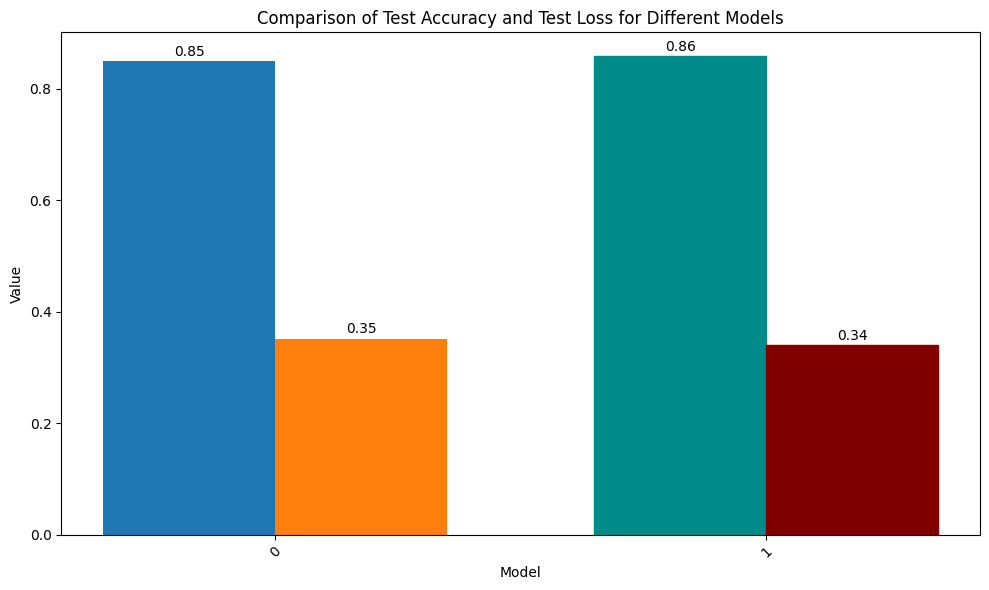

In [18]:
# Set the width of the bars
bar_width = 0.35

# Create an array of indices for the x-axis ticks
x_ticks = np.arange(len(results_df))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the test accuracy bars
accuracy_bars = ax.bar(x_ticks, results_df['Test_Accuracy'], width=bar_width, label='Test Accuracy')

# Plot the test loss bars
loss_bars = ax.bar(x_ticks + bar_width, results_df['Test_Loss'], width=bar_width, label='Test Loss')

# Find the index of the model with the maximum accuracy and minimum loss
max_accuracy_index = results_df['Test_Accuracy'].idxmax()
min_loss_index = results_df['Test_Loss'].idxmin()

# Highlight the bar for the model with the maximum accuracy
accuracy_bars[max_accuracy_index].set_color('darkcyan')

# Highlight the bar for the model with the minimum loss
loss_bars[min_loss_index].set_color('maroon')

# Set the x-axis ticks and labels
ax.set_xticks(x_ticks + bar_width / 2)
ax.set_xticklabels(results_df.index, rotation=45)

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Value')
ax.set_title('Comparison of Test Accuracy and Test Loss for Different Models')

# Add values on top of the bars
for i in range(len(results_df)):
    accuracy = results_df.loc[i, 'Test_Accuracy']
    loss = results_df.loc[i, 'Test_Loss']
    ax.text(i, accuracy + 0.01, f'{accuracy:.2f}', ha='center')
    ax.text(i + bar_width, loss + 0.01, f'{loss:.2f}', ha='center')

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
# save the results_df into new csv file
results_df[['Model', 'Test_Loss', 'Test_Accuracy']].to_csv('CNN_model_results.csv', index=False, header=True)